In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

2023-03-14 12:12:40.468616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 12:12:40.504456: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataset = np.load('/home/faster/Documents/wind_prediction/10m_u-component_of_wind_2022_hourly.npz')['arr_0']

In [3]:
dataset.shape

(730, 12, 201, 201)

In [4]:
dataset = dataset[:,:,64:128,64:128]

In [5]:
#add channel
dataset = np.expand_dims(dataset, axis=-1)

In [6]:
#dataset normalization
dataset = (dataset - dataset.min(axis=0)) / (dataset.max(axis=0) - dataset.min(axis=0))
#test = dataset.std()

In [7]:
dataset.shape

(730, 12, 64, 64, 1)

In [8]:

#indexes = np.arange(dataset.shape[0])
#np.random.shuffle(indexes)
#train_index = indexes[: int(0.9 * dataset.shape[0])]
#val_index = indexes[int(0.9 * dataset.shape[0]) :]
#train_dataset = dataset[train_index]
#val_dataset = dataset[val_index]
train_dataset = dataset[:600]
val_dataset = dataset[600:]

In [9]:
train_dataset.shape

(600, 12, 64, 64, 1)

In [10]:

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

def create_shifted_frames_seqto1(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, data.shape[1]-1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames_seqto1(train_dataset)
x_val, y_val = create_shifted_frames_seqto1(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (600, 11, 64, 64, 1), (600, 1, 64, 64, 1)
Validation Dataset Shapes: (130, 11, 64, 64, 1), (130, 1, 64, 64, 1)


Displaying frames for example 135.


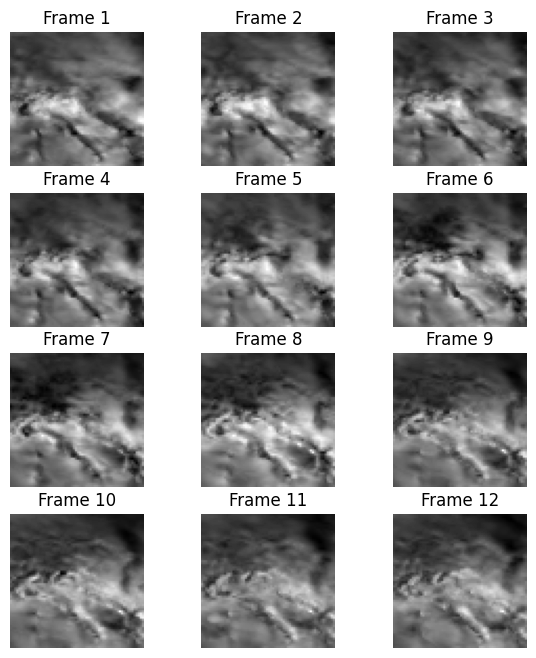

In [13]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 3, figsize=(7, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [12]:
print(tf. __version__)

2.10.0


In [15]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))


x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(inp)
x = layers.BatchNormalization()(x)


x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)


x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="tanh",
)(x)
#collapse filters 
x = layers.Reshape((1,64,64,64))(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 64, 64, 128  1651712   
                             )                                   
                                                                 
 batch_normalization_2 (Batc  (None, None, 64, 64, 128  512      
 hNormalization)             )                                   
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 64, 64, 64)  442624    
                                                                 
 batch_normalization_3 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                             

In [19]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 5
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/5
120/120 [==============================] - 37s 293ms/step - loss: 0.6337 - val_loss: 0.6348 - lr: 0.0010
Epoch 2/5
120/120 [==============================] - 36s 296ms/step - loss: 0.6330 - val_loss: 0.6347 - lr: 0.0010
Epoch 3/5
120/120 [==============================] - 35s 295ms/step - loss: 0.6331 - val_loss: 0.6430 - lr: 0.0010
Epoch 4/5
120/120 [==============================] - 36s 296ms/step - loss: 0.6329 - val_loss: 0.6348 - lr: 0.0010
Epoch 5/5
120/120 [==============================] - 35s 296ms/step - loss: 0.6327 - val_loss: 0.6355 - lr: 0.0010


In [29]:
#model.load_weights('wind.h5')

1/1 [==============================] - 0s 134ms/step


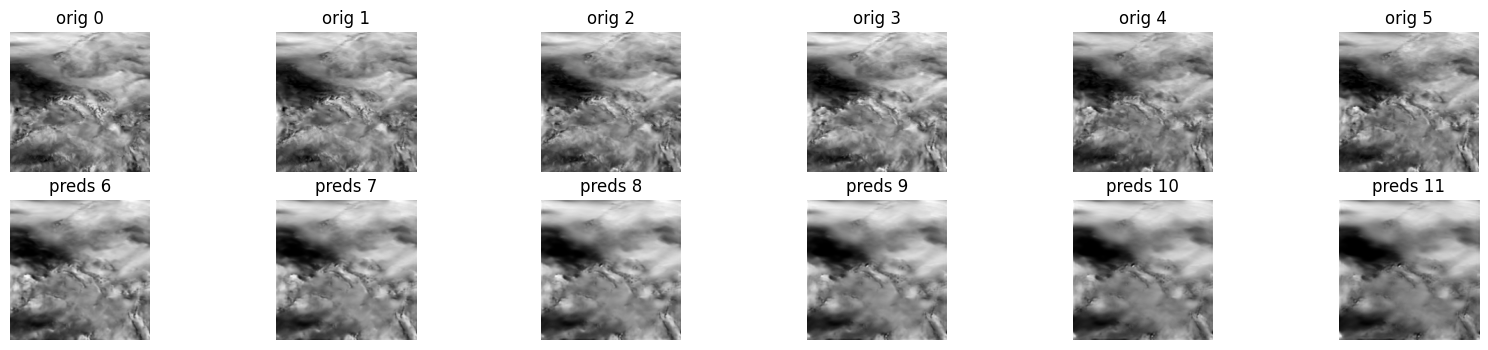

In [58]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

frames = example

# Predict a new set of 10 frames.
for _ in range(6):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.roll(frames, -1,axis=0)
    frames[-1] = new_prediction

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 6, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(example[idx+6]), cmap="gray")
    ax.set_title(f"orig {idx}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[6:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(frames[idx+6]), cmap="gray")
    ax.set_title(f"preds {idx + 6}")
    ax.axis("off")

# Display the figure.
plt.show()

In [59]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:12, ...]

# Predict a new set of 10 frames.
for _ in range(12):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.roll(frames, -1,axis=0)
    frames[-1] = new_prediction




1/1 [==============================] - 0s 123ms/step


In [30]:
frames.shape

(12, 201, 201, 1)

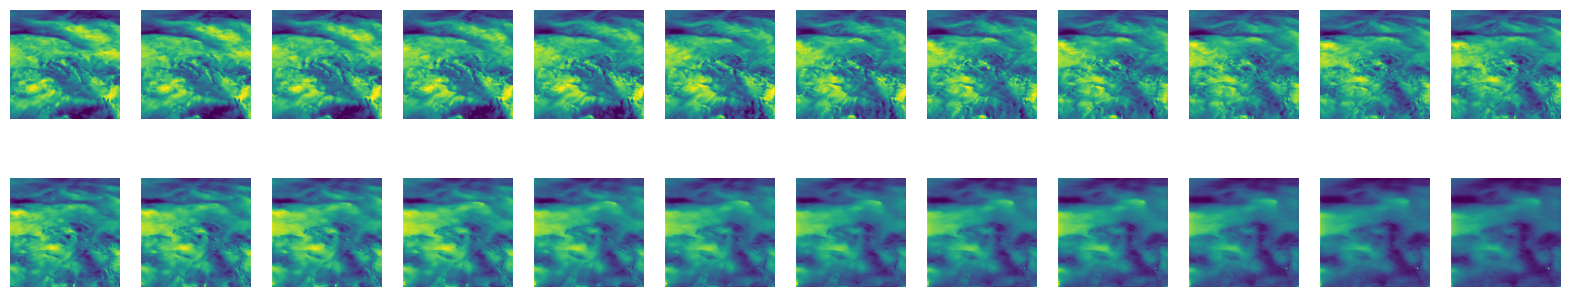

In [60]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 12, figsize=(20, 4))

for i in range(12):
  axes[0,i].imshow(example[i])
  axes[0,i].axis("off")
  axes[1,i].imshow(frames[i])
  axes[1,i].axis("off")

# Display the figure.
plt.show()

In [62]:
from datetime import datetime
images = []
for i in range(12):
    images.append((np.squeeze(example[i]) * 255).astype('uint8'))
for i in range(12):
    images.append((np.squeeze(frames[i]) * 255).astype('uint8'))
    
imageio.mimsave(str(datetime.now())+'fullpred.gif', images,fps=2)

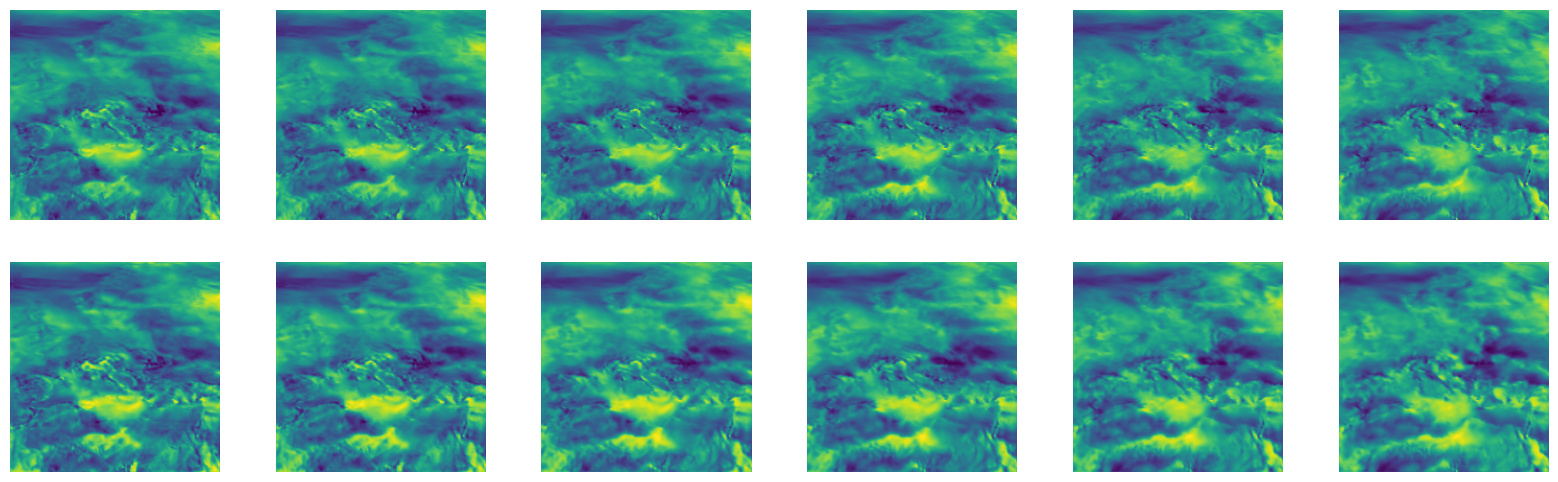

In [21]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 6, figsize=(20, 6))

for i in range(6):
  axes[0,i].imshow(original_frames[i])
  axes[0,i].axis("off")
  axes[1,i].imshow(new_predictions[i])
  axes[1,i].axis("off")


# Display the figure.
plt.show()